# Крокодил или часы
Автор: Николай Шаталов <br>
Дата: 13 мая 2018 года

Подключаем нужные нам библиотеки

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt

import time

Это нужно чтобы все было красиво в ноутбуке

In [2]:
from IPython import display

%matplotlib inline

### 1. Данные

In [3]:
dataset = torchvision.datasets.ImageFolder('./clocks_crocodiles/')
classes = dataset.classes

Данные предварительно преобразовываем: переводим PIL Image в тензор и нормализуем значения в отрезок [-1, 1]

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataset.transform = transform

Посмотрим на пример данных

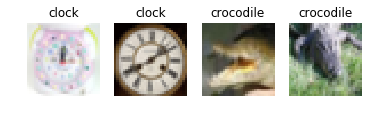

In [94]:
inds = [42, 256, 512, 898]
subset = [dataset[i] for i in inds]

for index, (image, label) in enumerate(subset):
    plt.subplot(1, 4, index + 1)
    plt.axis('off')
    image = image / 2 + 0.5  # unnormalize
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('{}'.format(classes[label]))

# plt.savefig("./img/datasample.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

### 2. Сверточная нейронная сеть

Создадим сверточную нейронную сеть с двумя сверточными слоями и тремя полносвязными слоями

In [95]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 18, 5)
        self.fc1 = nn.Linear(18 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 18 * 5 * 5)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [96]:
BATCH_SIZE = 4
N_SPLITS = 10
MAX_EPOCH = 50
eps = 1e-5

Для оценивания модели проведем кросс-валидацию на 10 фолдах

In [97]:
kf = KFold(N_SPLITS, shuffle=True)

In [153]:
nets = []
histories = []

start_time = time.time()
for net_num, (train_inds, val_inds) in enumerate(kf.split(dataset)):
    trainset = [dataset[i] for i in train_inds]
    valset = [dataset[i] for i in val_inds]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

    print("Net {}".format(net_num))
    net = Net()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0, weight_decay=0.005)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (epoch + 1) ** 0.5)
    
    # loss before fitting
    start_train_loss = 0.0
    start_train_accuracy = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        start_train_loss += loss.data[0]
        start_train_accuracy += (outputs.max(1)[1] == labels).sum().data[0]

    start_val_loss = 0.0
    start_val_accuracy = 0.0
    for i, data in enumerate(valloader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        start_val_loss += loss.data[0]
        start_val_accuracy += (outputs.max(1)[1] == labels).sum().data[0]

    # statistics
    history = dict()
    history['train_loss'] = [start_train_loss * BATCH_SIZE / len(trainset)]
    history['val_loss'] = [start_val_loss * BATCH_SIZE / len(valset)]
    history['train_accuracy'] = [start_train_accuracy / len(trainset)]
    history['val_accuracy'] = [start_val_accuracy / len(valset)]
    history['time'] = [0]
    history['epoch'] = [0]
    print("{:8.2f} s\tepoch: {}\ttrain loss: {:.4f}\ttest loss: {:.4f}".format(
        history['time'][0], history['epoch'][0],
        history['train_loss'][0], history['val_loss'][0] 
    ))

    # fitting
    for epoch in range(MAX_EPOCH):
        scheduler.step()
        full_train_loss = 0.0
        full_train_accuracy = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            full_train_loss += loss.data[0]
            full_train_accuracy += (outputs.max(1)[1] == labels).sum().data[0]

        full_val_loss = 0.0
        full_val_accuracy = 0.0
        for i, data in enumerate(valloader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            full_val_loss += loss.data[0]
            full_val_accuracy += (outputs.max(1)[1] == labels).sum().data[0]

        # counting loss and printing information
        history['train_loss'].append(full_train_loss * BATCH_SIZE / len(trainset))
        history['val_loss'].append(full_val_loss * BATCH_SIZE / len(valset))
        history['train_accuracy'].append(full_train_accuracy / len(trainset))
        history['val_accuracy'].append(full_val_accuracy / len(valset))
        history['time'].append(time.time() - start_time)
        history['epoch'].append(epoch + 1)
        display.clear_output(wait=True)
        tmp = min(20, len(history['train_loss']))
        print("Net {}".format(net_num))
        for i in range(tmp):
            print("{:8.2f} s\tepoch: {}\ttrain loss: {:.4f}\ttest loss: {:.4f}".format(
                    history['time'][i - tmp],
                    history['epoch'][i - tmp],
                    history['train_loss'][i - tmp],
                    history['val_loss'][i - tmp]
            ))
        if abs(history['train_loss'][-1] - history['train_loss'][-2]) < eps:
            break
    nets.append(net)
    histories.append(history)
    
print("Finished! It took {:.2f} s".format(time.time() - start_time))

Net 9
  355.52 s	epoch: 31	train loss: 0.1856	test loss: 0.2867
  356.24 s	epoch: 32	train loss: 0.1813	test loss: 0.2374
  357.02 s	epoch: 33	train loss: 0.1800	test loss: 0.1994
  357.74 s	epoch: 34	train loss: 0.1706	test loss: 0.2053
  358.46 s	epoch: 35	train loss: 0.1668	test loss: 0.2125
  359.21 s	epoch: 36	train loss: 0.1620	test loss: 0.2082
  359.91 s	epoch: 37	train loss: 0.1618	test loss: 0.2003
  360.61 s	epoch: 38	train loss: 0.1593	test loss: 0.2001
  361.33 s	epoch: 39	train loss: 0.1474	test loss: 0.2033
  362.06 s	epoch: 40	train loss: 0.1534	test loss: 0.2013
  362.76 s	epoch: 41	train loss: 0.1518	test loss: 0.2052
  363.50 s	epoch: 42	train loss: 0.1440	test loss: 0.2013
  364.21 s	epoch: 43	train loss: 0.1464	test loss: 0.2306
  364.92 s	epoch: 44	train loss: 0.1397	test loss: 0.2005
  365.63 s	epoch: 45	train loss: 0.1390	test loss: 0.1966
  366.34 s	epoch: 46	train loss: 0.1320	test loss: 0.2344
  367.05 s	epoch: 47	train loss: 0.1344	test loss: 0.2047
  367.75

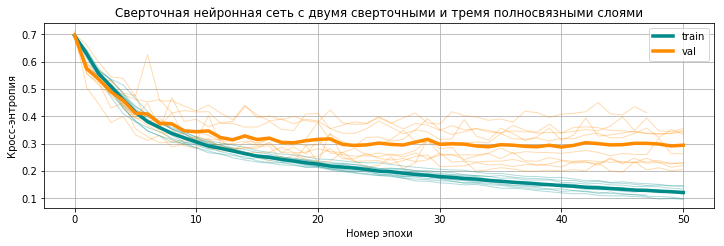

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(12,3.4))

train_loss = np.empty((N_SPLITS, len(histories[0]['train_loss'])))
val_loss = np.empty((N_SPLITS, len(histories[0]['val_loss'])))

for i, history in enumerate(histories):
    ax.plot(np.arange(len(history['train_loss'])), history['train_loss'], linewidth=1, alpha=0.3, c='darkcyan')
    ax.plot(np.arange(len(history['val_loss'])), history['val_loss'], linewidth=1, alpha=0.3, c='darkorange')
    
    train_loss[i, :len(history['train_loss'])] = np.array(history['train_loss'])
    train_loss[i, len(history['train_loss']):] = history['train_loss'][-1]
    val_loss[i, :len(history['val_loss'])] = np.array(history['val_loss'])
    val_loss[i, len(history['val_loss']):] = history['val_loss'][-1]
    
ax.plot(train_loss.mean(axis=0), label='train', linewidth=3.5, c='darkcyan')
ax.plot(val_loss.mean(axis=0), label='val', linewidth=3.5, c='darkorange')
ax.set_title("Сверточная нейронная сеть с двумя сверточными и тремя полносвязными слоями")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Кросс-энтропия")

ax.legend()
ax.grid()

# plt.savefig("./img/loss_crossval.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

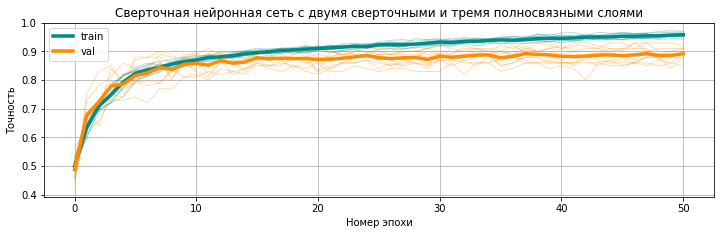

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(12,3.2))

train_accuracy = np.empty((N_SPLITS, len(histories[0]['train_accuracy'])))
val_accuracy = np.empty((N_SPLITS, len(histories[0]['val_accuracy'])))

for i, history in enumerate(histories):
    ax.plot(np.arange(len(history['train_accuracy'])), history['train_accuracy'], linewidth=1, alpha=0.3, c='darkcyan')
    ax.plot(np.arange(len(history['val_accuracy'])), history['val_accuracy'], linewidth=1, alpha=0.3, c='darkorange')
    
    train_accuracy[i, :len(history['train_accuracy'])] = np.array(history['train_accuracy'])
    train_accuracy[i, len(history['train_accuracy']):] = history['train_accuracy'][-1]
    val_accuracy[i, :len(history['val_accuracy'])] = np.array(history['val_accuracy'])
    val_accuracy[i, len(history['val_accuracy']):] = history['val_accuracy'][-1]
    
ax.plot(train_accuracy.mean(axis=0), label='train', linewidth=3.5, c='darkcyan')
ax.plot(val_accuracy.mean(axis=0), label='val', linewidth=3.5, c='darkorange')
ax.set_title("Сверточная нейронная сеть с двумя сверточными и тремя полносвязными слоями")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Точность")

ax.legend()
ax.grid()

# plt.savefig("./img/accuracy_crossval.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [158]:
print("train")
print("accuracy:\t{:.4f}".format(train_accuracy[:, -1].mean()))
print("logloss:\t{:.4f}".format(train_loss[:, -1].mean()))
print("val")
print("accuracy:\t{:.4f}".format(val_accuracy[:, -1].mean()))
print("logloss:\t{:.4f}".format(val_loss[:, -1].mean()))

train
accuracy:	0.9582
logloss:	0.1219
val
accuracy:	0.8920
logloss:	0.2947


### 3. Неуверенность сети

Обучим нейросети и посмотрим, на каких изображениях из валидационной выборки алгоритм не знает к какому классу его отнести и на каких изображения алгоритм сильно ошибается

In [356]:
kf = KFold(N_SPLITS)

In [357]:
y_pred = np.empty((len(dataset), len(classes)))
y_test = np.empty(len(dataset), dtype=np.int)

In [358]:
print("Fitting neural networks...")
start_time = time.time()

zero_index = 0
for net_num, (train_inds, val_inds) in enumerate(kf.split(dataset)):
    trainset = [dataset[i] for i in train_inds]
    valset = [dataset[i] for i in val_inds]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

    net = Net()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0, weight_decay=0.005)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (epoch + 1) ** 0.5)
    
    for epoch in range(MAX_EPOCH):
        scheduler.step()
        full_train_loss = 0.0
        full_train_accuracy = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            full_train_loss += loss.data[0]
            full_train_accuracy += (outputs.max(1)[1] == labels).sum().data[0]

    i = zero_index
    for data in valloader:
        inputs, labels = data
        for j in range(len(inputs)):
            output = F.softmax(net(Variable(inputs[j : j + 1])), dim=1)
            y_pred[i] = output.data.numpy()
            y_test[i] = labels[j]
            i += 1
    zero_index = i
        
print("Finished! It took {:.2f} s".format(time.time() - start_time))

Fitting neural networks...
Finished! It took 344.12 s


Изображения, на которых алгоритм неуверен

In [384]:
inds = np.abs(y_pred[:, 0] - y_pred[:, 1]).argsort()

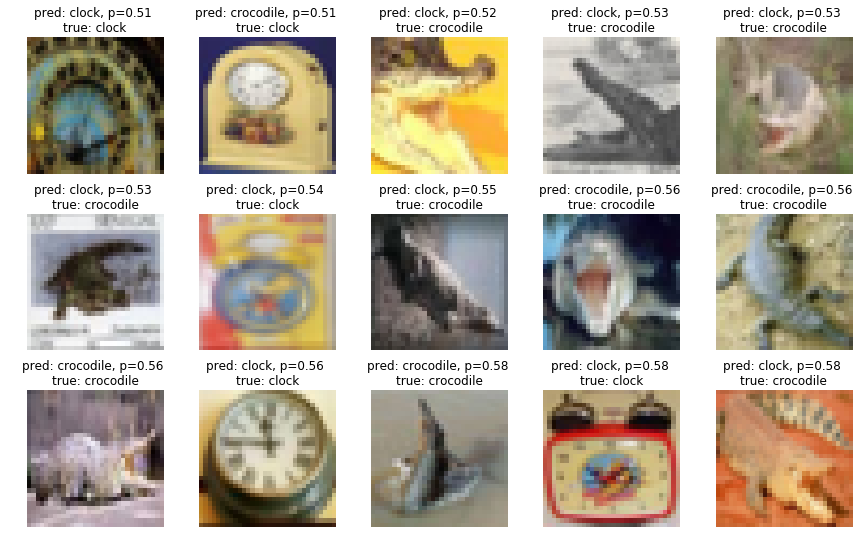

In [390]:
subset = [(dataset[i][0], y_pred[i].max(), y_pred[i].argmax(), dataset[i][1]) for i in inds[1:31:2]]

fig, axes = plt.subplots(3, 5, figsize=(12, 7.4))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)
for index, (image, prob, label_pred, label_test) in enumerate(subset):
    axes[index // 5, index % 5].axis('off')
    image = image / 2 + 0.5  # unnormalize
    npimg = image.numpy()
    axes[index // 5, index % 5].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[index // 5, index % 5].set_title('pred: {}, p={:.2f} \ntrue: {}'.format(classes[label_pred], prob, classes[label_test]))
# plt.savefig("./img/uncertain_objects.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

In [393]:
inds = (y_pred[np.arange(len(y_test)), y_test] - y_pred[np.arange(len(y_test)), 1 - y_test]).argsort()

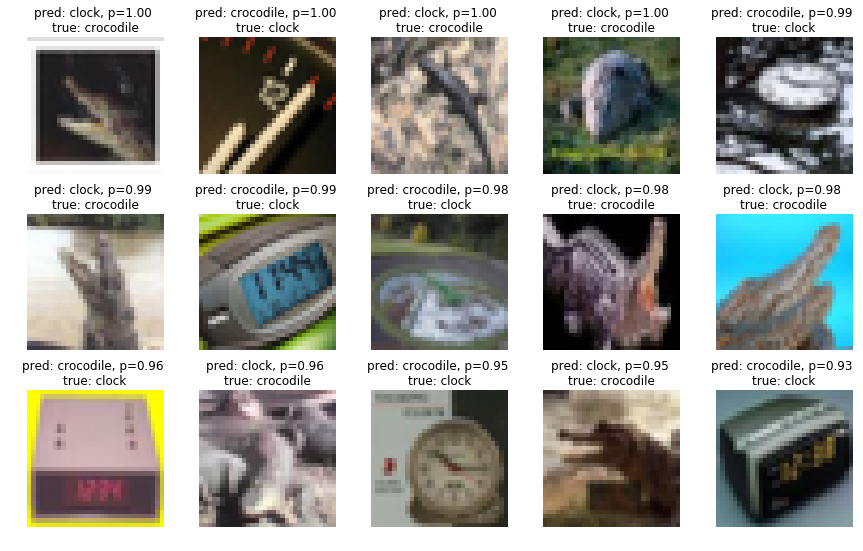

In [395]:
subset = [(dataset[i][0], y_pred[i].max(), y_pred[i].argmax(), dataset[i][1]) for i in inds[1:31:2]]

fig, axes = plt.subplots(3, 5, figsize=(12, 7.4))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)
for index, (image, prob, label_pred, label_test) in enumerate(subset):
    axes[index // 5, index % 5].axis('off')
    image = image / 2 + 0.5  # unnormalize
    npimg = image.numpy()
    axes[index // 5, index % 5].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[index // 5, index % 5].set_title('pred: {}, p={:.2f} \ntrue: {}'.format(classes[label_pred], prob, classes[label_test]))
# plt.savefig("./img/uncertain_objects_2.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

### 4. Генерация изображений, похожих на крокодила и на часы

Построим автоэнкодер

In [541]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.tconv1 = nn.ConvTranspose2d(10, 6, 5)
        self.unpool1 = nn.Upsample((7, 7), mode='bilinear')
        self.tconv2 = nn.ConvTranspose2d(6, 3, 5)
        self.unpool2 = nn.Upsample((28, 28), mode='bilinear')
    
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.tconv1(x))
        x = self.tconv2(x)
        return x
    
    def encode(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        return x
    
    def decode(self, x):
        x = F.tanh(self.tconv1(x))
        x = self.tconv2(x)
        return x

Разобьем датасет на датасет с крокодилами и на датасет с часами и обучим на них автоэнкодеры

In [542]:
clockset = [dataset[i] for i in range(500)]
crockset = [dataset[i] for i in range(500, 1000)]

clockloader = torch.utils.data.DataLoader(clockset, batch_size=BATCH_SIZE, shuffle=True)
crockloader = torch.utils.data.DataLoader(crockset, batch_size=BATCH_SIZE, shuffle=True)

In [543]:
clock_net = ConvAutoEncoder()
crock_net = ConvAutoEncoder()

nets = [clock_net, crock_net]
loaders = [clockloader, crockloader]

In [544]:
MAX_EPOCH = 100
eps = 10 ** -5

start_time = time.time()
for net_num, (net, loader) in enumerate(zip(nets, loaders)):
    print("Net {}".format(net_num))
    
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0, weight_decay=0.001)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (epoch + 1) ** 0.5)

    # loss before fitting
    start_loss = 0
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        start_loss += loss.data[0]

    history = dict()
    history['loss'] = [start_loss / len(loader)]
    history['time'] = [0]
    history['epoch'] = [0]
    print("{:8.2f} s\tepoch: {}\tloss: {:.4f}".format(history['time'][0], history['epoch'][0], history['loss'][0]))

    for epoch in range(MAX_EPOCH):
        scheduler.step()
        full_loss = 0.0
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            full_loss += loss.data[0]

        total_loss = full_loss / len(loader)
        history['loss'].append(total_loss)
        history['time'].append(time.time() - start_time)
        history['epoch'].append(epoch + 1)
        display.clear_output(wait=True)
        tmp = min(20, len(history['loss']))
        print("Net {}".format(net_num))
        for i in range(tmp):
            print("{:8.2f} s\tepoch: {}\tloss: {:.4f}".format(history['time'][i - tmp], history['epoch'][i - tmp], history['loss'][i - tmp]))
        if abs(history['loss'][-1] - history['loss'][-2]) < eps:
            break
        
print("Finished! It took {:.2f} s".format(time.time() - start_time))

Net 1
  171.87 s	epoch: 81	loss: 0.0254
  172.79 s	epoch: 82	loss: 0.0254
  173.67 s	epoch: 83	loss: 0.0253
  174.58 s	epoch: 84	loss: 0.0253
  175.49 s	epoch: 85	loss: 0.0253
  176.36 s	epoch: 86	loss: 0.0252
  177.28 s	epoch: 87	loss: 0.0252
  178.16 s	epoch: 88	loss: 0.0251
  179.04 s	epoch: 89	loss: 0.0251
  179.93 s	epoch: 90	loss: 0.0251
  180.81 s	epoch: 91	loss: 0.0251
  181.69 s	epoch: 92	loss: 0.0250
  182.59 s	epoch: 93	loss: 0.0250
  183.49 s	epoch: 94	loss: 0.0250
  184.39 s	epoch: 95	loss: 0.0249
  185.31 s	epoch: 96	loss: 0.0249
  186.19 s	epoch: 97	loss: 0.0249
  187.11 s	epoch: 98	loss: 0.0249
  187.98 s	epoch: 99	loss: 0.0248
  188.96 s	epoch: 100	loss: 0.0248
Finished! It took 188.96 s


In [669]:
dataiter = iter(clockloader)
images_clocks, labels_clocks = dataiter.next()

dataiter = iter(crockloader)
images_crocks, labels_crocks = dataiter.next()

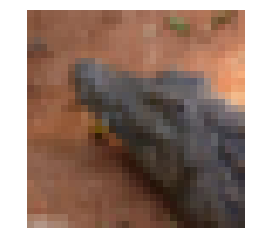

In [697]:
plt.axis('off')
image = images_crocks[1]
image = image / 2 + 0.5  # unnormalize
npimg = image.numpy()
plt.savefig
plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.savefig("./img/crocko.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

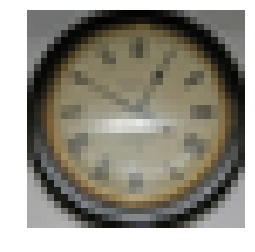

In [676]:
plt.axis('off')
image = images_clocks[1]
image = image / 2 + 0.5  # unnormalize
npimg = image.numpy()
plt.savefig
plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.savefig("./img/clocko.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

Смешаем результаты

In [692]:
something = clock_net.decode(0.8 * clock_net.encode(Variable(images_clocks)) + 0.2 * crock_net.encode(Variable(images_crocks)))

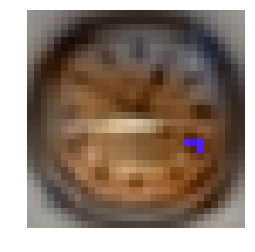

In [693]:
image = something[1]
plt.axis('off')
image = image / 2 + 0.5  # unnormalize
npimg = image.data.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.savefig("./img/clocko_crocko.pdf", format='pdf', bbox_inches='tight', pad_inches=0)